(page:adsorption_isobar)=
# Adsorption Isobars

This script generates adsorption isobars by evaluating the average energy of formation of the 5 % lowest energy structures in the [data set of the oxidized octahedral nanoparticles](https://doi.org/10.5281/zenodo.6322004) as a function of the degree of oxidation. 

The script analyzes the entire data set, which is *ca.* 90,000 data points, and calculates the O / Pt ratio $x_\mathrm{O} = \frac{n_\mathrm{O}}{n_\mathrm{Pt}}$ as well as the energy of formation $\Delta E_\mathrm{F} = E_\mathrm{tot}^\mathrm{NP-ox} - E_\mathrm{tot}^\mathrm{NP-clean} - n_\mathrm{O}\ \mu_\mathrm{O}$. Here, $E_\mathrm{tot}^\mathrm{NP-ox}$ is the total energy of the ReaxFF-GCMC output structure in question, $E_\mathrm{tot}^\mathrm{NP-clean}$ is the ReaxFF total energy of the pristine, non-oxidized reference octahedral nanoparticle, $n_\mathrm{O}$ is the number of oxygen atoms in the structure, and $\mu_\mathrm{O}$ is the chemical potential of oxygen under the given temperature $T$ and pressure $p$ conditions. The code features an extrapolation algorithm which is fed by thermochemical data ($H - H_0$ and $S$) for oxygen from the [NIST-JANAF Thermochemical Tables, 4th Edition (M. Chase)](https://janaf.nist.gov/) and which can find the chemical potential for any $T$ beyond the values discretized in 100 K steps that are fed into the model.

The script selects the 5 % structures with the lowest $E_\mathrm{F}$ generated at each $T$, $p$ condition (where $p$ = UHV or NAP and $T$ = 200-1200 K) and shows their average $x_\mathrm{O}$ as a function of the temperature. UHV (ultra-high vacuum): $10^{-10}$ mbar; NAP (near-ambient pressure): 1 mbar. 

Start by reading in the data set.

In [1]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

Some prework is needed before we can start calculating the formation energy results. We will first set up a curve fitting procedure for the chemical potential `mu` of $\mathrm{O}_2$ for a range of temperatures using `scipy.optimize.curve_fit`. The output of this fit is a set of coefficients, `popt`, which we can use to extrapolate `mu` for any temperature. Note that the most reliable results are obtained with this fit within the originally supplied temperature regime, 0-1000 K - remember that thermochemical properties can change abruptly at phase transitions which can make fitting tricky. 

First we define the fit function.

In [2]:
def chemPot(T, a, b, c, d, e, f, g):
    """Extrapolate chemical potential"""

    # Find tilde_mu corresponding to T.
    tilde_mu = 0.
    tilde_mu += f * T * T * T * T * T * T
    tilde_mu += g * T * T * T * T * T
    tilde_mu += a * T * T * T * T
    tilde_mu += b * T * T * T
    tilde_mu += c * T * T
    tilde_mu += d * T + e

    return tilde_mu

Perform the curve fit of the `chemPot` function using `mu` from the [NIST-JANAF thermochemical tables](https://janaf.nist.gov/) for the temperature range 0-1000 K. 

In [3]:
from scipy.optimize import curve_fit

# Temperature and tilde_mu values from NIST-JANAF thermochemical tables.
T = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
tildemu = [0, -0.149412173, -0.281157674, -0.547523739, -0.764835950,
           -0.990053499, -1.221741022, -1.458992202, -1.701091526,
           -1.947627033, -2.198143395]

# popt and pcov hold the fit parameters.
popt, pcov = curve_fit(chemPot, T, tildemu)

Next, we will loop through all entries (structures) in the data set. For each structure, we need to calculated the following values for the subsequent analysis:
* the ratio of oxygen to platinum atoms, $x_\mathrm{O}$, and
* energy of formation, $\Delta E_\mathrm{F}$.

$\Delta E_\mathrm{F}$ is calculated as

$\Delta E_\mathrm{F} = E_\mathrm{tot}^\mathrm{NP-ox} - E_\mathrm{tot}^\mathrm{NP-clean} - n_\mathrm{O}\ \mu_\mathrm{O}$,

where $E_\mathrm{tot}^\mathrm{NP-ox}$ is the total ReaxFF energy of the oxidized nanoparticle systems, $E_\mathrm{tot}^\mathrm{NP-clean}$ is the reference total energy of the pristine nanoparticle without any oxygen atoms, $n_\mathrm{O}$ is the number of oxygen atoms in the oxidized nanoparticle system, and $\mu_\mathrm{O}$ is the temperature- and pressure-dependent chemical potential of oxygen.

To make things easier below, we can already pre-define some values. For example, we'll need some conversion factors to go from the energy unit in the `geo_MC` files, $\mathrm{kcal\ mol}^{-1}$, to eV. Also, the reference ReaxFF total energy values of $\mathrm{O}_2$ and the pristine nanoparticle system are constants which we can pre-define.

In [4]:
kcal2eV = 23.06035     # Conversion factor kcal mol-1 to eV.
n_Pt = 489             # Number of Pt atoms in clean octahedral nanoparticle.
Eref = -59782.464426   # ReaxFF total energy of clean particle.
Eref /= kcal2eV
EO2 = -127.283886      # ReaxFF total energy + ZPE for O2.
EO2 /= kcal2eV
kB = 8.61734e-5        # k Boltzmann in eV/K.
pdict = {"NAP": 1e-3,
         "UHV": 1e-13} # Pressure in bar.

In the following, we will execute the calculation of $\Delta E_\mathrm{F}$ as well as of $\mu_\mathrm{O}$ for every structure in the data set.

Because $\mu_\mathrm{O}$ is a function of temperature and pressure, it needs to be re-calculated for every structure using the `chemPot` function defined above.

In [5]:
import numpy as np

results = {"NAP": {}, "UHV": {}}
for index, structure in data.iterrows():

    # Get temperature, pressure, and total energy.
    T = structure["T"]
    p = structure["p"]
    Etot = structure["Etot"] / kcal2eV

    # Extrapolate tilde_mu of O2 for given T.
    tilde_mu = chemPot(T, popt[0], popt[1], popt[2], popt[3],
                       popt[4], popt[5], popt[6])
    
    # Introduce pressure dependency and add ReaxFF total energy + ZPE.
    mu = tilde_mu + kB * T * np.log(pdict[p]) + EO2

    # Calculate coverage.
    n_O = structure["n_O"]
    xO = n_O / n_Pt
    xOString = "{:.1f}".format(xO)

    # Calculate energy of formation.
    Eform = Etot - Eref - n_O * 0.5 * mu

    # Fill into results dictionary.
    if not T in results[p]:
        results[p].update({T: [(xO, Eform)]})
    else:
        results[p][T].append((xO, Eform))

The `results` dictionary is now ordered by pressure first and temperature second, and each temperature `key` entry holds tuples of ($x_\mathrm{O}$, $\Delta E_\mathrm{F}$).

The last step is to calculate the average formation energy values and prepare the data for visualization. The goal is to show the average $x_\mathrm{O}$ ratio of the 5 % structures with the lowest $\Delta E_\mathrm{F}$ on the $x$ axis against the temperature on the $y$ axis for the `UHV` and `NAP` data sets separately. 

To achieve this, we will sort the `results` dictionaries by `Eform` in ascending fashion so that the lowest-energy (most negative) values are on the top of the list. Then, select the first 5 % entries and calculate the average $x_\mathrm{O}$.

In [6]:
from operator import itemgetter

avgRes = {"NAP": {}, "UHV": {}}
for tag, resdict in results.items():
    for T, values in resdict.items():
        
        # Sort list by Eform (ascending).
        values = sorted(values, key=itemgetter(1))

        # Select 5 % values at the top of the list.
        fivepct = int(len(values) * 0.05) - 1
        bestxO = [xO for xO, Eform in values[:fivepct]]

        # Calculate average x_O values and save to new results dict.
        avgxO = sum(bestxO) / fivepct
        avgRes[tag].update({T: avgxO})

This data can now be visualized using `pyplot`.

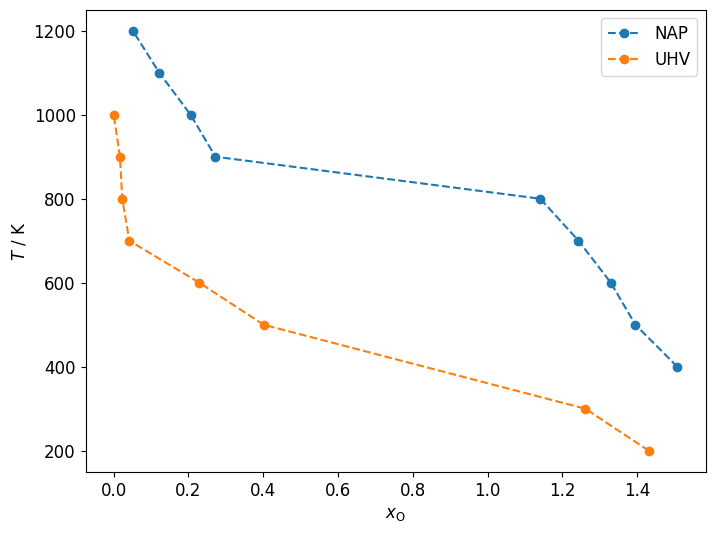

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})
for pressure, resdict in avgRes.items():
    y, x = zip(*sorted(resdict.items()))
    plt.plot(x, y, "--o", label=pressure)
plt.xlabel("$x_{\mathrm{O}}$")
plt.ylabel("$T$ / K")
plt.legend()
plt.show()